# 🧠 Flask Service Testing Notebook for OHLCV Models

This notebook is designed to test the Flask API that serves the trained machine learning models. The service runs inside a Docker container, exposing an HTTP endpoint for predictions.

---

# 🚀 How to Start the Prediction Service

Before running the cells below, make sure the Flask service is running. From your project root, execute the following commands in your terminal:

### Build the Docker image
```bash
docker build -t coffee-defect-api -f deployment/flask/Dockerfile .
```

### Run the Flask service inside a container
```bash

docker run -it --rm -p 9696:9696 coffee-defect-api
```

Once the service is running and listening on http://0.0.0.0:9696, you can proceed to execute the next cells in this notebook to send test requests.

**(THIS NOTEBOOK CAN ALSO BE USED TO TEST THE KUBERNETIES DEPLOYMENT)**

In [1]:
import requests
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import io
import random

In [2]:
API_URL = "http://localhost:9696/predict"

In [3]:
health = requests.get(API_URL.replace("predict", "health")).json()
health

{'status': 'ok', 'timestamp': '2026-02-02 23:48:38.746287'}

In [4]:
DATA_DIR = Path("../../data/processed/test/Broken")
assert DATA_DIR.exists(), "Dataset path not found"

In [5]:
# Get all image files recursively
image_paths = list(DATA_DIR.rglob("*.jpg")) + list(DATA_DIR.rglob("*.png"))

print(f"Found {len(image_paths)} images")

# Randomly select one
img_path = random.choice(image_paths)
print("Selected image:", img_path)

Found 13 images
Selected image: ../../data/processed/test/Broken/Broken_22.jpg


Text(0.5, 1.0, 'Input image\nBroken')

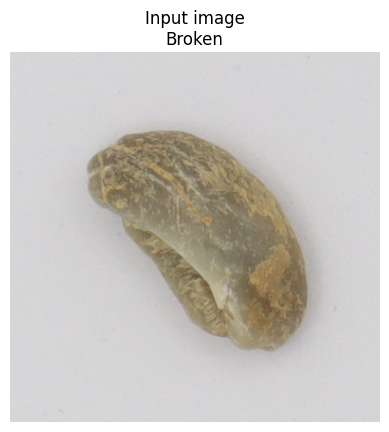

In [6]:
img = Image.open(img_path).convert("RGB")

plt.imshow(img)
plt.axis("off")
plt.title(f"Input image\n{img_path.parent.name}")

In [7]:
buf = io.BytesIO()
img.save(buf, format="JPEG")
buf.seek(0)

files = {
    "file": (img_path.name, buf, "image/jpeg")
}

response = requests.post(API_URL, files=files)

response.status_code


200

In [8]:
response.json()

{'class_id': 0, 'class_name': 'black', 'confidence': 0.8643274903297424}

In [9]:
result = response.json()

print("🫘 Ground truth folder:", img_path.parent.name)
print("🤖 Predicted class:", result["class_name"])
print("📊 Confidence:", f"{result['confidence']*100:.2f}%")

🫘 Ground truth folder: Broken
🤖 Predicted class: black
📊 Confidence: 86.43%


In [10]:
for _ in range(5):
    img_path = random.choice(image_paths)
    img = Image.open(img_path).convert("RGB")

    buf = io.BytesIO()
    img.save(buf, format="JPEG")
    buf.seek(0)

    files = {"file": (img_path.name, buf, "image/jpeg")}
    response = requests.post(API_URL, files=files)
    result = response.json()

    print(
        f"GT: {img_path.parent.name:20s} | "
        f"PRED: {result['class_name']:20s} | "
        f"CONF: {result['confidence']:.3f}"
    )


GT: Broken               | PRED: black                | CONF: 0.978
GT: Broken               | PRED: stones               | CONF: 0.299
GT: Broken               | PRED: black                | CONF: 0.939
GT: Broken               | PRED: shrivelled           | CONF: 0.342
GT: Broken               | PRED: black                | CONF: 0.997
